In [109]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from DELG_Class import DELG

class ImageRetrieval:
    def __init__(self, model_class, model_path, device, use_global=True, use_local=True):
        """
        model_class: class of the model (DELG or DELF)
        model_path: path to .pth file
        device: 'cuda' or 'cpu'
        use_global: whether the model produces global descriptors
        use_local: whether the model produces local descriptors
        """
        self.device = device
        self.use_global = use_global
        self.use_local = use_local

        # Initialize model
        self.model = model_class(
            pretrained=False,
            use_global=use_global,
            use_local=use_local
        ).to(device)
        
        # Load weights
        checkpoint = torch.load(model_path, map_location=device)
        if "model_state_dict" in checkpoint:
             state_dict = checkpoint["model_state_dict"]
        else:
            state_dict = checkpoint  # already raw weights

        self.model.load_state_dict(state_dict)
        self.model.eval()


        # Feature storage
        self.global_features = {}  # image_path -> global descriptor
        self.local_features = {}   # image_path -> local descriptors

    @torch.no_grad()
    def extract_features(self, image_loader):
        #Extract features for all images in a dataloader.
        for imgs, paths in tqdm(image_loader, desc="Extracting features"):
            imgs = imgs.to(self.device)
            feats = self.model(imgs)

            for i, path in enumerate(paths):
                if self.use_global and 'global' in feats:
                    self.global_features[path] = feats['global'][i].cpu().numpy()

                if self.use_local and 'local' in feats:
                    local_data = feats['local']
                    descriptors = local_data['descriptors'][i].cpu().numpy()

                    # Save keypoints if available
                    keypoints = None
                    if 'keypoints' in local_data:
                        keypoints = local_data['keypoints'][i].cpu().numpy()

                    self.local_features[path] = {
                        'descriptors': descriptors,
                        'keypoints': keypoints
                    }


    def save_features(self, file_path):
        """Save global and local features to disk."""
        np.savez_compressed(
            file_path,
            global_features=self.global_features,
            local_features=self.local_features
        )
        print(f"Features saved to {file_path}")
        

    def load_features(self, file_path):
        """Load previously saved features."""
        data = np.load(file_path, allow_pickle=True)
        self.global_features = data['global_features'].item()
        self.local_features = data['local_features'].item()
        print(f"Features loaded from {file_path}")


    def retrieve_global(self, query_feat, top_k=5):
        """Retrieve top-k candidates using global descriptors."""
        if not self.use_global:
            raise ValueError("This model cannot produce global descriptors.")

         # Print query feature
        #print("=== Query feature (first 10 values) ===")
        #print(query_feat[:10], "...\n")  # only first 10 values for readability

        all_feats = np.array(list(self.global_features.values()))
        all_paths = list(self.global_features.keys())

        # --- Print all global features before cosine ---
        #print("=== Global features before cosine similarity ===")
        #for i, (path, feat) in enumerate(self.global_features.items()):
        #    print(f"{i}: {path} -> {feat[:5]} ...")  # print first 5 values

        sims = cosine_similarity(query_feat[None, :], all_feats)[0]

        # --- Print similarity scores after cosine ---
        #print("\n=== Cosine similarity with query feature ===")
        #for i, path in enumerate(all_paths):
        #    print(f"{i}: {path} -> similarity: {sims[i]:.4f}")

        top_idx = np.argsort(-sims)[:top_k]
        #print ("\n=== Top-k retrieval results ===")
        #for rank, idx in enumerate(top_idx, start=1):
        #    print(f"Rank {rank}: {all_paths[idx]} with similarity {sims[idx]:.4f}")
            
        return [all_paths[i] for i in top_idx], sims[top_idx]

    def rerank_local(self, query_local, candidate_paths, top_k=5):
        """Re-rank top-k candidates using local descriptors."""
        if not self.use_local:
            raise ValueError("This model cannot produce local descriptors.")

        scores = []
        for path in candidate_paths:
            target_local = self.local_features[path]['descriptors'] #here
            sim_matrix = cosine_similarity(query_local, target_local)
            score = sim_matrix.max(axis=1).mean()  # max per query descriptor, then mean
            scores.append(score)

        sorted_idx = np.argsort(-np.array(scores))[:top_k]
        return [candidate_paths[i] for i in sorted_idx], np.array(scores)[sorted_idx]

    @torch.no_grad()
    def query(self, query_img, top_k=5, rerank_model=None):
        """
        query_img: torch tensor (1,3,H,W)
        top_k: number of results
        rerank_model: another ImageRetrieval instance (local descriptor for reranking)
        """
        query_img = query_img.to(self.device)
        feats = self.model(query_img)

        # Global retrieval
        if self.use_global and 'global' in feats:
            query_global = feats['global'][0].cpu().numpy()
            results, _ = self.retrieve_global(query_global, top_k=top_k)
        else:
            results = list(self.local_features.keys())[:top_k]

        # Local reranking
        if rerank_model is not None:
            query_local = feats['local']['descriptors'][0].cpu().numpy()
            results, _ = rerank_model.rerank_local(query_local, results, top_k=top_k)

        return results
    



In [110]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import os

class ImageFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, f) 
                            for f in os.listdir(root_dir) 
                            if f.lower().endswith((".jpg", ".png", ".jpeg"))]
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, path

# Transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Dataset & DataLoader
dataset = ImageFolderDataset("dataset", transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=False)


In [115]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

delg_retriever = ImageRetrieval(
    model_class=DELG,      
    model_path="allModel/delg_global_pretrained_only.pth",    #delg_global_pretrained_only.pth
    device="cuda",
    use_global=True,        
    use_local=False        
)

delg_retriever.extract_features(loader)
# Save the extracted features
delg_retriever.save_features("features/delg_global_pretrained_only_features.npz")

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Phumi\AppData\Local\Temp\ipykernel_9612\1873788097.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

Features saved to features/delg_global_pretrained_only_features.npz


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


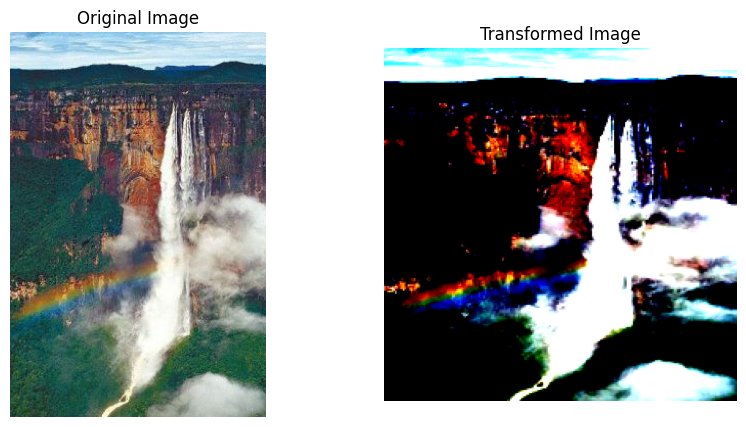

In [91]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
from DELG_Class import DELG

# Load query image
#img_path = "dataset/train_Stonehenge_2320.jpg"
img_path = "data/test/325.jpg"
img = Image.open(img_path).convert("RGB")

# Define transform (match model input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply transform and add batch dimension
query_img = transform(img).unsqueeze(0)  # shape [1,3,224,224]

# Denormalize for plotting
#mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
#std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
#img_plot = query_img.squeeze(0) * std + mean  # undo normalization
#img_plot = torch.clamp(img_plot, 0, 1)       # ensure values in [0,1]

# Plot side by side
plt.figure(figsize=(10,5))

# Original image
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")

# Transformed image
plt.subplot(1,2,2)
#plt.imshow(img_plot.permute(1, 2, 0).numpy())
plt.imshow(query_img.squeeze(0).permute(1, 2, 0).detach().numpy())
plt.axis('off')
plt.title("Transformed Image")

plt.show()


c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Phumi\AppData\Local\Temp\ipykernel_9612\3050064999.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

Features loaded from features/delg_global_finetune_local_pretrained_features.npz
=== Query feature (first 10 values) ===
[2.0108521e-08 2.0108521e-08 2.0108521e-08 2.9296484e-02 2.0108521e-08
 5.9287590e-06 2.0108521e-08 2.0108521e-08 2.6107309e-02 2.0108521e-08] ...

=== Global features before cosine similarity ===
0: dataset\train_Antarctica_0.jpg -> [2.2911156e-02 1.6042144e-08 3.1582415e-02 1.6042144e-08 3.5204824e-02] ...
1: dataset\train_Antarctica_1.jpg -> [2.2622446e-02 1.2103668e-08 3.6910430e-02 1.2103668e-08 3.6729939e-02] ...
2: dataset\train_Antarctica_10.jpg -> [2.2715053e-02 1.8750862e-08 3.1673338e-02 1.8750862e-08 3.6982812e-02] ...
3: dataset\train_Antarctica_100.jpg -> [2.2697298e-02 2.1631774e-08 3.2178264e-02 2.1631774e-08 3.6361996e-02] ...
4: dataset\train_Antarctica_101.jpg -> [3.4981418e-02 2.5608648e-08 1.6686784e-02 2.5608648e-08 5.1278137e-02] ...
5: dataset\train_Antarctica_102.jpg -> [2.2750290e-02 1.4247952e-08 3.5183217e-02 1.4247952e-08 3.6116630e-02] .

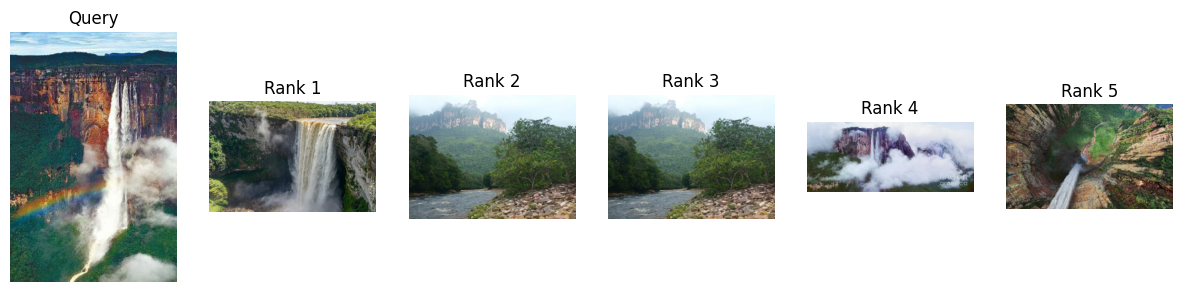

In [92]:
delg_retriever = ImageRetrieval(
    model_class=DELG,      
    model_path="allModel/delg_global_finetune_local_pretrained.pth",   
    #allModel/delg_global_only_pretrained.pth
    #allModel/delg_both_pretrained.pth
    #allModel/delg_global_finetune_no_local.pth
    #allModel/allModel/delg_global_finetune_local_pretrained.pth  
    #allModel/allModel/delg_global_finetune_local_pretrained_v2.pth
    device="cuda",
    use_global=True,        
    use_local=True        
)

#load previously saved features
#delg_retriever.load_features("features/delg_global_finetune_local_pretrained_features.npz")
delg_retriever.load_features("features/delg_global_finetune_local_pretrained_features.npz")
#
# Run retrieval
results = delg_retriever.query(query_img, top_k=5)
print("Top-5 retrieved images:", results)

# Plot query and top-5 results
plt.figure(figsize=(15,5))

# Original query
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Query")

# Retrieved images
for i, path in enumerate(results):
    retrieved_img = Image.open(path).convert("RGB")
    plt.subplot(1, 6, i+2)
    plt.imshow(retrieved_img)
    plt.axis('off')
    plt.title(f"Rank {i+1}")

plt.show()

In [32]:
# See which image paths are stored
print("Number of images with global features:", len(delg_retriever.global_features))
print("First 10 image paths:")
for i, path in enumerate(delg_retriever.global_features.keys()):
    if i >= 10:
        break
    print(path)


Number of images with global features: 2872
First 10 image paths:
dataset\train_Antarctica_0.jpg
dataset\train_Antarctica_1.jpg
dataset\train_Antarctica_10.jpg
dataset\train_Antarctica_100.jpg
dataset\train_Antarctica_101.jpg
dataset\train_Antarctica_102.jpg
dataset\train_Antarctica_103.jpg
dataset\train_Antarctica_104.jpg
dataset\train_Antarctica_105.jpg
dataset\train_Antarctica_106.jpg


In [35]:
query_path = "dataset\\train_Antarctica_103.jpg"

if query_path in delg_retriever.global_features:
    print("Found query feature!")
    query_feat = delg_retriever.global_features[query_path]
    print("Feature shape:", query_feat.shape)
else:
    print("Query path NOT found in global features.")


Found query feature!
Feature shape: (2048,)


In [120]:
"""
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score
import numpy as np

def evaluate_single_query_ap(retriever, query_path, landmark_keyword, top_k=None):
    
    #Compute Average Precision (AP) for a single query image.
    
    #retriever: ImageRetrieval instance with loaded features
    #query_path: str, full path to the query image
    #landmark_keyword: str, e.g., "Stonehenge"
    #top_k: int or None, limit number of retrieved results
    
    all_paths = list(retriever.global_features.keys())
    all_feats = np.array(list(retriever.global_features.values()))
    
    query_feat = retriever.global_features[query_path]
    sims = cosine_similarity(query_feat[None, :], all_feats)[0]
    
    if top_k is not None:
        top_idx = np.argsort(-sims)[:top_k]
        sims = sims[top_idx]
        retrieved_paths = [all_paths[i] for i in top_idx]
    else:
        retrieved_paths = all_paths
    
    # Binary labels: 1 if retrieved image has same landmark
    y_true = np.array([1 if landmark_keyword in p else 0 for p in retrieved_paths])
    y_score = sims
    
    ap = average_precision_score(y_true, y_score)
    print(f"AP for query {query_path}: {ap:.4f}")
    
    
    # Optional: print top-10 results
    #print("\nTop-10 retrievals:")
    #for rank, (p, score, label) in enumerate(zip(retrieved_paths[:10], y_score[:10], y_true[:10]), 1):
    #    print(f"{rank}: {p}, similarity: {score:.4f}, relevant: {label}")
    
    print("\nAll retrieved results:")
    for rank, (p, score, label) in enumerate(zip(retrieved_paths, y_score, y_true), 1):
        print(f"{rank}: {p}, similarity: {score:.4f}, relevant: {label}")

    
    return ap


delg_retriever = ImageRetrieval(
    model_class=DELG,
    model_path="allModel/delg_global_finetune_local_pretrained.pth",
    device="cuda",
    use_global=True,
    use_local=True
)

delg_retriever.load_features("features/delg_global_finetune_local_pretrained_features.npz")

# Usage
query_path = "dataset\\train_Stonehenge_2320.jpg"
ap = evaluate_single_query_ap(delg_retriever, query_path, landmark_keyword="Stonehenge", top_k=None)
"""


'\nfrom sklearn.metrics.pairwise import cosine_similarity\nfrom sklearn.metrics import average_precision_score\nimport numpy as np\n\ndef evaluate_single_query_ap(retriever, query_path, landmark_keyword, top_k=None):\n    \n    #Compute Average Precision (AP) for a single query image.\n    \n    #retriever: ImageRetrieval instance with loaded features\n    #query_path: str, full path to the query image\n    #landmark_keyword: str, e.g., "Stonehenge"\n    #top_k: int or None, limit number of retrieved results\n    \n    all_paths = list(retriever.global_features.keys())\n    all_feats = np.array(list(retriever.global_features.values()))\n    \n    query_feat = retriever.global_features[query_path]\n    sims = cosine_similarity(query_feat[None, :], all_feats)[0]\n    \n    if top_k is not None:\n        top_idx = np.argsort(-sims)[:top_k]\n        sims = sims[top_idx]\n        retrieved_paths = [all_paths[i] for i in top_idx]\n    else:\n        retrieved_paths = all_paths\n    \n    # B

In [121]:
from PIL import Image
import torch
import numpy as np
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score

def evaluate_single_query_ap(retriever, query_path, landmark_keyword, top_k=None):
    """
    Compute Average Precision (AP) for a single query image.
    Works with new images not in retriever.global_features.
    """
    all_paths = list(retriever.global_features.keys())
    all_feats = np.array(list(retriever.global_features.values()))
    
    # --- Extract feature for query image ---
    if query_path in retriever.global_features:
        query_feat = retriever.global_features[query_path]
    else:
        retriever.model.eval()
        img = Image.open(query_path).convert("RGB")
        
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # adjust to your model input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
        img_tensor = transform(img).unsqueeze(0).to(retriever.device)
        with torch.no_grad():
            outputs = retriever.model(img_tensor)
            
            # Access the global descriptor from the dict
            if isinstance(outputs, dict) and "global_descriptor" in outputs:
                query_feat = outputs["global_descriptor"].cpu().numpy().squeeze()
            elif isinstance(outputs, dict) and "global" in outputs:
                query_feat = outputs["global"].cpu().numpy().squeeze()
            else:
                # fallback if model returns tensor directly
                query_feat = outputs.cpu().numpy().squeeze()
    
    # --- Compute cosine similarity ---
    sims = cosine_similarity(query_feat[None, :], all_feats)[0]
    
    # --- Sort top-k ---
    if top_k is not None:
        top_idx = np.argsort(-sims)[:top_k]
        sims = sims[top_idx]
        retrieved_paths = [all_paths[i] for i in top_idx]
    else:
        retrieved_paths = all_paths
    
    # --- Compute relevance labels ---
    y_true = np.array([1 if landmark_keyword in p else 0 for p in retrieved_paths])
    y_score = sims
    
    # --- Compute Average Precision ---
    ap = average_precision_score(y_true, y_score)
    print(f"AP for query {landmark_keyword}: {ap:.4f}")
    

    # --- Print all retrieved results ---
    #print("\nAll retrieved results:")
    #for rank, (p, score, label) in enumerate(zip(retrieved_paths, y_score, y_true), 1):
    #    print(f"{rank}: {p}, similarity: {score:.4f}, relevant: {label}")
    
    return ap


In [97]:
query_path = "data\\test\\325.jpg"
ap = evaluate_single_query_ap(delg_retriever, query_path, landmark_keyword="Niagara Falls", top_k=None)

AP for query Niagara Falls: 0.3150

All retrieved results:
1: dataset\train_Antarctica_0.jpg, similarity: 0.3693, relevant: 0
2: dataset\train_Antarctica_1.jpg, similarity: 0.3668, relevant: 0
3: dataset\train_Antarctica_10.jpg, similarity: 0.3684, relevant: 0
4: dataset\train_Antarctica_100.jpg, similarity: 0.3718, relevant: 0
5: dataset\train_Antarctica_101.jpg, similarity: 0.4023, relevant: 0
6: dataset\train_Antarctica_102.jpg, similarity: 0.3679, relevant: 0
7: dataset\train_Antarctica_103.jpg, similarity: 0.3691, relevant: 0
8: dataset\train_Antarctica_104.jpg, similarity: 0.3704, relevant: 0
9: dataset\train_Antarctica_105.jpg, similarity: 0.3685, relevant: 0
10: dataset\train_Antarctica_106.jpg, similarity: 0.3699, relevant: 0
11: dataset\train_Antarctica_107.jpg, similarity: 0.3807, relevant: 0
12: dataset\train_Antarctica_108.jpg, similarity: 0.3706, relevant: 0
13: dataset\train_Antarctica_109.jpg, similarity: 0.3705, relevant: 0
14: dataset\train_Antarctica_11.jpeg, similar

In [122]:
landmarks = ["Antarctica", "Burj Khalifa", "Chich-n Itz", "Christ the Reedemer Statue", "Eiffel Tower", "Giant-s Causeway", "Great Wall Of China",
    "Himalaya", "Machu Pichu", "Niagara Falls", "Pyramids Of Giza", "Roman Colosseum", "Santorini", "Statue Of Liberty", "Stonehenge",
    "Taj Mahal", "The Blue Grotto" , "Venezuela Angel Falls"
    ]


query_paths = [
    "data/test/5.jpg",
    "data/test/9.jpg",
    "data/test/2.AtractivoGrande_2352019081130.jpg",
    "data/test/90.jpg",
    "data/test/60.01-eiffel-tower.jpg",
    "data/test/37.831300.jpg",
    "data/test/43.great-wall-of-china-facts-2.jpg",
    "data/test/63.hangchendzonga-national-par.jpg",
    "data/test/50.machu-picchu-cusco.jpg",
    "data/test/48.american-falls1-2__medium.jpg",
    "data/test/180.jpg",
    "data/test/77.jpg",
    "data/test/171.jpg",
    "data/test/79.jpg",
    "data/test/110.jpg",
    "data/test/119.jpg",
    "data/test/92.jpg",
    "data/test/325.jpg"
]


# delg_global_pretrained_only.pth

In [123]:
delg_retriever = ImageRetrieval(
    model_class=DELG,
    model_path="allModel/delg_global_pretrained_only.pth",
    device="cuda",
    use_global=True,
    use_local=False
)

delg_retriever.load_features("features/delg_global_pretrained_only_features.npz")

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Phumi\AppData\Local\Temp\ipykernel_9612\1873788097.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

Features loaded from features/delg_global_pretrained_only_features.npz


In [124]:
all_aps = []

for query_path, landmark in zip(query_paths, landmarks):
    ap = evaluate_single_query_ap(delg_retriever, query_path, landmark_keyword=landmark, top_k=None)
    all_aps.append(ap)

# Compute mean Average Precision (mAP)
map_score = np.mean(all_aps)
print("")
print(f"\nMean Average Precision (mAP) over all landmarks: {map_score:.4f}")

AP for query Antarctica: 0.6392
AP for query Burj Khalifa: 0.5272
AP for query Chich-n Itz: 0.9066
AP for query Christ the Reedemer Statue: 0.6600
AP for query Eiffel Tower: 0.6744
AP for query Giant-s Causeway: 0.7453
AP for query Great Wall Of China: 0.5698
AP for query Himalaya: 0.6317
AP for query Machu Pichu: 0.8386
AP for query Niagara Falls: 0.9223
AP for query Pyramids Of Giza: 0.7793
AP for query Roman Colosseum: 0.7883
AP for query Santorini: 0.8711
AP for query Statue Of Liberty: 0.4031
AP for query Stonehenge: 0.9561
AP for query Taj Mahal: 0.9524
AP for query The Blue Grotto: 0.8077
AP for query Venezuela Angel Falls: 0.4202


Mean Average Precision (mAP) over all landmarks: 0.7274


# delg_both_pretrained.pth

In [125]:
delg_retriever = ImageRetrieval(
    model_class=DELG,
    model_path="allModel/delg_both_pretrained.pth",
    device="cuda",
    use_global=True,
    use_local=True
)

delg_retriever.load_features("features/delg_both_pretrained_features.npz")

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Phumi\AppData\Local\Temp\ipykernel_9612\1873788097.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

Features loaded from features/delg_both_pretrained_features.npz


In [127]:
all_aps = []

for query_path, landmark in zip(query_paths, landmarks):
    ap = evaluate_single_query_ap(delg_retriever, query_path, landmark_keyword=landmark, top_k=None)
    all_aps.append(ap)

# Compute mean Average Precision (mAP)
map_score = np.mean(all_aps)
print("")
print(f"\nMean Average Precision (mAP) over all landmarks: {map_score:.4f}")

AP for query Antarctica: 0.6420
AP for query Burj Khalifa: 0.5329
AP for query Chich-n Itz: 0.9069
AP for query Christ the Reedemer Statue: 0.6609
AP for query Eiffel Tower: 0.6719
AP for query Giant-s Causeway: 0.7447
AP for query Great Wall Of China: 0.5722
AP for query Himalaya: 0.6293
AP for query Machu Pichu: 0.8368
AP for query Niagara Falls: 0.9215
AP for query Pyramids Of Giza: 0.7802
AP for query Roman Colosseum: 0.7918
AP for query Santorini: 0.8713
AP for query Statue Of Liberty: 0.4031
AP for query Stonehenge: 0.9560
AP for query Taj Mahal: 0.9537
AP for query The Blue Grotto: 0.8099
AP for query Venezuela Angel Falls: 0.4188


Mean Average Precision (mAP) over all landmarks: 0.7280


# delg_global_finetune_no_local.pth

In [129]:
delg_retriever = ImageRetrieval(
    model_class=DELG,
    model_path="allModel/delg_global_finetune_no_local.pth",
    device="cuda",
    use_global=True,
    use_local=False
)

delg_retriever.load_features("features/delg_global_finetune_no_local_features.npz")

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Phumi\AppData\Local\Temp\ipykernel_9612\1873788097.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

Features loaded from features/delg_global_finetune_no_local_features.npz


In [130]:
all_aps = []

for query_path, landmark in zip(query_paths, landmarks):
    ap = evaluate_single_query_ap(delg_retriever, query_path, landmark_keyword=landmark, top_k=None)
    all_aps.append(ap)

# Compute mean Average Precision (mAP)
map_score = np.mean(all_aps)
print("")
print(f"\nMean Average Precision (mAP) over all landmarks: {map_score:.4f}")

AP for query Antarctica: 0.9966
AP for query Burj Khalifa: 0.9900
AP for query Chich-n Itz: 0.9785
AP for query Christ the Reedemer Statue: 0.9361
AP for query Eiffel Tower: 0.9907
AP for query Giant-s Causeway: 0.9971
AP for query Great Wall Of China: 0.9808
AP for query Himalaya: 0.9464
AP for query Machu Pichu: 0.9810
AP for query Niagara Falls: 0.9993
AP for query Pyramids Of Giza: 0.9887
AP for query Roman Colosseum: 0.9868
AP for query Santorini: 0.9993
AP for query Statue Of Liberty: 0.9824
AP for query Stonehenge: 0.9948
AP for query Taj Mahal: 0.9792
AP for query The Blue Grotto: 0.9997
AP for query Venezuela Angel Falls: 0.9947


Mean Average Precision (mAP) over all landmarks: 0.9846


# delg_global_finetune_local_pretrained.pth

In [131]:
delg_retriever = ImageRetrieval(
    model_class=DELG,
    model_path="allModel/delg_global_finetune_local_pretrained.pth",
    device="cuda",
    use_global=True,
    use_local=True
)

delg_retriever.load_features("features/delg_global_finetune_local_pretrained_features.npz")

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Phumi\AppData\Local\Temp\ipykernel_9612\1873788097.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

Features loaded from features/delg_global_finetune_local_pretrained_features.npz


In [132]:
all_aps = []

for query_path, landmark in zip(query_paths, landmarks):
    ap = evaluate_single_query_ap(delg_retriever, query_path, landmark_keyword=landmark, top_k=None)
    all_aps.append(ap)

# Compute mean Average Precision (mAP)
map_score = np.mean(all_aps)
print(f"\nMean Average Precision (mAP) over all landmarks: {map_score:.4f}")

AP for query Antarctica: 0.9966
AP for query Burj Khalifa: 0.9891
AP for query Chich-n Itz: 0.9737
AP for query Christ the Reedemer Statue: 0.9810
AP for query Eiffel Tower: 0.9973
AP for query Giant-s Causeway: 0.9950
AP for query Great Wall Of China: 0.9962
AP for query Himalaya: 0.9757
AP for query Machu Pichu: 0.9994
AP for query Niagara Falls: 0.9981
AP for query Pyramids Of Giza: 0.9974
AP for query Roman Colosseum: 0.9956
AP for query Santorini: 0.9958
AP for query Statue Of Liberty: 0.9921
AP for query Stonehenge: 0.9999
AP for query Taj Mahal: 1.0000
AP for query The Blue Grotto: 1.0000
AP for query Venezuela Angel Falls: 0.9974

Mean Average Precision (mAP) over all landmarks: 0.9933


# delg_global_finetune_local_pretrained_v2.pth

In [133]:
delg_retriever = ImageRetrieval(
    model_class=DELG,
    model_path="allModel/delg_global_finetune_local_pretrained_v2.pth",
    device="cuda",
    use_global=True,
    use_local=True
)

delg_retriever.load_features("features/delg_global_finetune_local_pretrained_v2_features.npz")

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Phumi\AppData\Local\Temp\ipykernel_9612\1873788097.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

Features loaded from features/delg_global_finetune_local_pretrained_v2_features.npz


In [134]:
all_aps = []

for query_path, landmark in zip(query_paths, landmarks):
    ap = evaluate_single_query_ap(delg_retriever, query_path, landmark_keyword=landmark, top_k=None)
    all_aps.append(ap)

# Compute mean Average Precision (mAP)
map_score = np.mean(all_aps)
print(f"\nMean Average Precision (mAP) over all landmarks: {map_score:.4f}")

AP for query Antarctica: 0.9964
AP for query Burj Khalifa: 0.9930
AP for query Chich-n Itz: 0.9970
AP for query Christ the Reedemer Statue: 0.9954
AP for query Eiffel Tower: 0.9958
AP for query Giant-s Causeway: 0.9994
AP for query Great Wall Of China: 0.9971
AP for query Himalaya: 0.9663
AP for query Machu Pichu: 0.9878
AP for query Niagara Falls: 0.9983
AP for query Pyramids Of Giza: 0.9950
AP for query Roman Colosseum: 1.0000
AP for query Santorini: 0.9990
AP for query Statue Of Liberty: 0.9911
AP for query Stonehenge: 1.0000
AP for query Taj Mahal: 0.9970
AP for query The Blue Grotto: 0.9998
AP for query Venezuela Angel Falls: 0.9990

Mean Average Precision (mAP) over all landmarks: 0.9948


In [17]:
# Load features
delg_retriever.load_features("features/delg_global_finetune_local_pretrained_features.npz")

# Print all global features
print("===== All global features =====")
for i, (path, feat) in enumerate(delg_retriever.global_features.items()):
    print(f"{i}: {path} -> {feat[:5]} ...")  # only print first 5 values to keep it short


Features loaded from features/delg_global_finetune_local_pretrained_features.npz
===== All global features =====
0: dataset\train_Antarctica_0.jpg -> [2.2911156e-02 1.6042144e-08 3.1582415e-02 1.6042144e-08 3.5204824e-02] ...
1: dataset\train_Antarctica_1.jpg -> [2.2622446e-02 1.2103668e-08 3.6910430e-02 1.2103668e-08 3.6729939e-02] ...
2: dataset\train_Antarctica_10.jpg -> [2.2715053e-02 1.8750862e-08 3.1673338e-02 1.8750862e-08 3.6982812e-02] ...
3: dataset\train_Antarctica_100.jpg -> [2.2697298e-02 2.1631774e-08 3.2178264e-02 2.1631774e-08 3.6361996e-02] ...
4: dataset\train_Antarctica_101.jpg -> [3.4981418e-02 2.5608648e-08 1.6686784e-02 2.5608648e-08 5.1278137e-02] ...
5: dataset\train_Antarctica_102.jpg -> [2.2750290e-02 1.4247952e-08 3.5183217e-02 1.4247952e-08 3.6116630e-02] ...
6: dataset\train_Antarctica_103.jpg -> [2.2432564e-02 1.5986071e-08 3.3658616e-02 1.5986071e-08 3.6418002e-02] ...
7: dataset\train_Antarctica_104.jpg -> [2.3228584e-02 1.8860078e-08 3.2750532e-02 1.886

In [137]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def visualize_local_matches(query_local, retrieved_local, query_img, retrieved_img, max_matches=50):
    q_desc = query_local['descriptors'].astype(np.float32)
    r_desc = retrieved_local['descriptors'].astype(np.float32)
    q_kp = query_local['keypoints']
    r_kp = retrieved_local['keypoints']

    if q_kp is None or r_kp is None:
        print("⚠️ Keypoints missing — cannot show true correspondences.")
        return

    q_kp_cv = [cv2.KeyPoint(float(x), float(y), 1) for (x, y) in q_kp]
    r_kp_cv = [cv2.KeyPoint(float(x), float(y), 1) for (x, y) in r_kp]

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(q_desc, r_desc)
    matches = sorted(matches, key=lambda x: x.distance)[:max_matches]

    img1 = np.array(query_img)[:, :, ::-1]
    img2 = np.array(retrieved_img)[:, :, ::-1]

    matched_img = cv2.drawMatches(img1, q_kp_cv, img2, r_kp_cv, matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Local Feature Correspondences ({len(matches)} matches)")
    plt.show()



In [138]:
delg_retriever.load_features("features/delg_both_pretrained_features.npz")
query_local = delg_retriever.local_features['dataset\\train_Stonehenge_2320.jpg']
retrieved_local = delg_retriever.local_features[results[4]]  # top-1 result

visualize_local_matches(query_local, retrieved_local, img, Image.open(results[4]).convert("RGB"))

Features loaded from features/delg_both_pretrained_features.npz
⚠️ Keypoints missing — cannot show true correspondences.


In [144]:
import os
from PIL import Image
import torch
from torchvision import transforms
from DELG_Class import DELG
from tqdm import tqdm
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DELG model ---
model = DELG(pretrained=False, use_global=True, use_local=True).to(device)

# Load your trained weights
checkpoint = torch.load("allModel/delg_both_pretrained.pth", map_location=device)
if "model_state_dict" in checkpoint:
    model.load_state_dict(checkpoint["model_state_dict"])
else:
    model.load_state_dict(checkpoint)  # raw weights

model.eval()

model.eval()

# --- Preprocessing ---
transform = transforms.Compose([
    transforms.Resize((480,480)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# --- Database folder ---
dataset_folder = "dataset/"

# --- Lists to store features & paths ---
#all_global_feats = []
all_local_feats = []
all_attention_maps = []
all_paths = []

# --- Loop through all images ---
for root, _, files in os.walk(dataset_folder):
    for f in tqdm(files):
        if not f.lower().endswith(('.jpg','.jpeg','.png')):
            continue

        img_path = os.path.join(root, f)
        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0).to(device)  # [1,3,480,480]

        with torch.no_grad():
            out = model(x)

            # --- Global feature (for retrieval) ---
            #gfeat = out['global'][0].cpu().numpy()   # [2048]
            #all_global_feats.append(gfeat)

            # --- Local descriptors (optional, for re-ranking / correspondences) ---
            local_desc = out['local']['descriptors'][0].cpu().numpy()  # [H*W, 2048]
            att_map = out['local']['attention'][0,0].cpu().numpy()    # [H,W]
            all_local_feats.append(local_desc)
            all_attention_maps.append(att_map)

            # --- Keep track of paths ---
            all_paths.append(img_path)

# --- Convert lists to numpy arrays ---
#all_global_feats = np.stack(all_global_feats)
# local descriptors: keep as list since H*W may vary if images differ in size
# attention maps: keep as list


c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Phumi\AppData\Local\Temp\ipykernel_9612\50771729.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_on

In [ ]:
np.savez_compressed(
    "dataset_local_features.npz",
    local_feats=all_local_feats,      # [H*W, 2048] per image
    attention_maps=all_attention_maps,
    paths=all_paths # [H, W] per image
)


SyntaxError: invalid syntax. Perhaps you forgot a comma? (2324941701.py, line 4)

In [ ]:
import numpy as np

data = np.load("dataset_local_features.npz", allow_pickle=True)

all_paths = data['paths']           # list of image paths
all_local = data['local_feats']    # list of [H*W, 2048]
all_attention_maps = data['attention_maps'] # list of [H,W]


#all_local_feats = []
#all_attention_maps = []
#all_paths = []

c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Phumi\anaconda3\envs\yolo\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


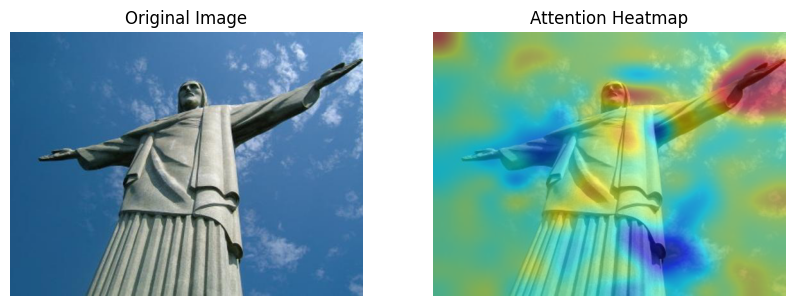

In [169]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# --- Pick an image ---
img_idx = all_paths.index("dataset/train_Christ the Reedemer Statue_576.jpg")
att_map = all_attention_maps[img_idx]  # [H,W]
img = Image.open(all_paths[img_idx]).convert("RGB")

# --- Resize attention to image size ---
att_resized = cv2.resize(att_map, img.size, interpolation=cv2.INTER_CUBIC)
att_resized = (att_resized - att_resized.min()) / (att_resized.max() - att_resized.min())

# --- Overlay heatmap ---
heatmap = cv2.applyColorMap(np.uint8(255*att_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = np.float32(img)*0.5 + np.float32(heatmap)*0.5
overlay = np.clip(overlay/overlay.max(),0,1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Attention Heatmap")
plt.axis('off')
plt.show()


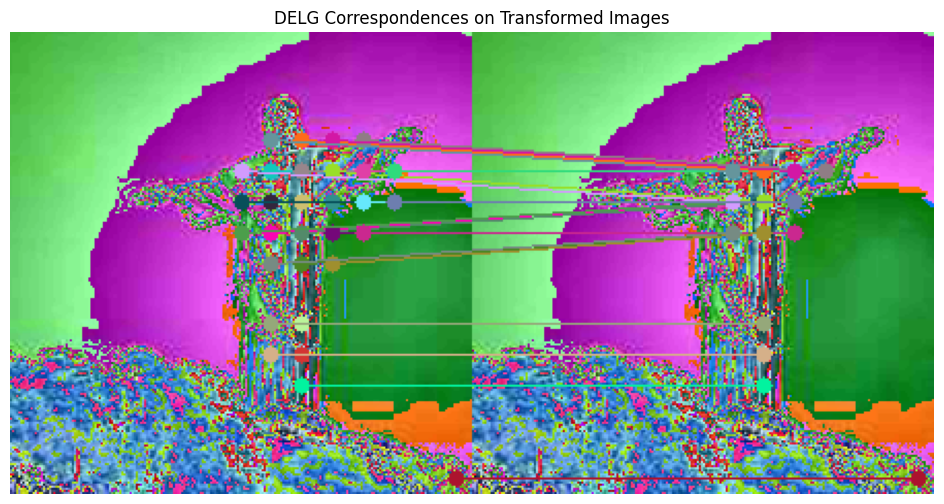

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import cv2

# --- Transformation used for DELG ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # same as during feature extraction
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Pick two images from your dataset ---
img1_path = "dataset/train_Christ the Reedemer Statue_527.jpg"
img2_path = "dataset/train_Christ the Reedemer Statue_527.jpg"

# --- Load and transform images ---
img1 = Image.open(img1_path).convert("RGB")
img2 = Image.open(img2_path).convert("RGB")

H, W = 224, 224  # transformed image size
img1_trans = np.array(transform(img1).permute(1, 2, 0) * 255).astype(np.uint8)
img2_trans = np.array(transform(img2).permute(1, 2, 0) * 255).astype(np.uint8)

# --- Load local descriptors from your precomputed DELG features ---
# Replace these with your actual all_local_feats and all_paths
img1_idx = all_paths.index(img1_path)
img2_idx = all_paths.index(img2_path)

desc1 = all_local_feats[img1_idx]  # [num_desc1, feat_dim]
desc2 = all_local_feats[img2_idx]  # [num_desc2, feat_dim]

# --- Compute keypoints positions for plotting ---
feat_map_h1, feat_map_w1 = int(np.sqrt(desc1.shape[0])), int(np.sqrt(desc1.shape[0]))
kpts1_y = (np.arange(feat_map_h1).repeat(feat_map_w1) + 0.5) * (H / feat_map_h1)
kpts1_x = (np.tile(np.arange(feat_map_w1), feat_map_h1) + 0.5) * (W / feat_map_w1)
kpts1 = np.stack([kpts1_x, kpts1_y], axis=1)

feat_map_h2, feat_map_w2 = int(np.sqrt(desc2.shape[0])), int(np.sqrt(desc2.shape[0]))
kpts2_y = (np.arange(feat_map_h2).repeat(feat_map_w2) + 0.5) * (H / feat_map_h2)
kpts2_x = (np.tile(np.arange(feat_map_w2), feat_map_h2) + 0.5) * (W / feat_map_w2)
kpts2 = np.stack([kpts2_x, kpts2_y], axis=1)

# --- Compute similarity and pick top matches ---
sim = np.dot(desc1, desc2.T)
matches = [(i, np.argmax(sim[i]), sim[i, np.argmax(sim[i])]) for i in range(len(kpts1))]
matches = sorted(matches, key=lambda x: -x[2])[:30]  # top 30 matches

# --- Draw matches ---
H_off = img1_trans.shape[1]  # offset for the second image
match_img = np.hstack([img1_trans, img2_trans]).copy()

for i, j, s in matches:
    x1, y1 = kpts1[i]
    x2, y2 = kpts2[j]
    color = tuple(np.random.randint(0, 255, 3).tolist())
    cv2.circle(match_img, (int(x1), int(y1)), 4, color, -1)
    cv2.circle(match_img, (int(x2) + H_off, int(y2)), 4, color, -1)
    cv2.line(match_img, (int(x1), int(y1)), (int(x2) + H_off, int(y2)), color, 1)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.imshow(match_img)
plt.axis('off')
plt.title("DELG Correspondences on Transformed Images")
plt.show()


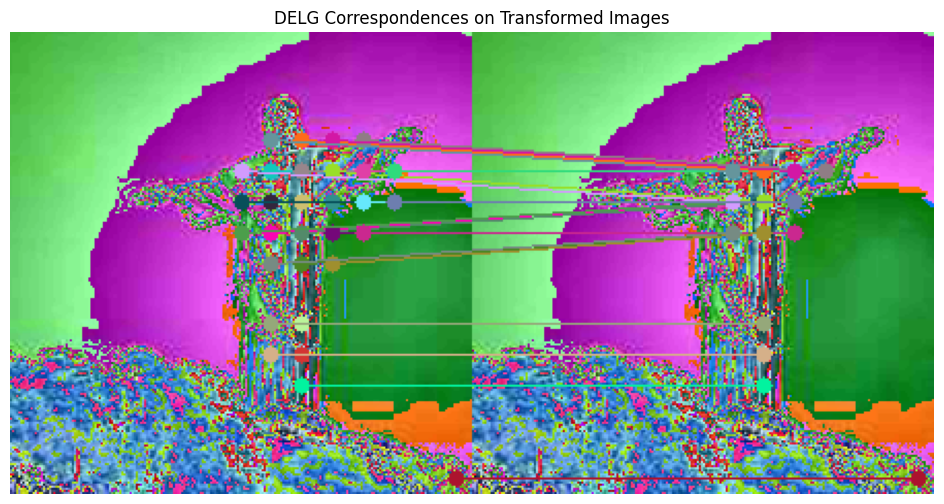

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import cv2

# --- Transformation used for DELG ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # same as during feature extraction
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Pick two images from your dataset ---
img1_path = "dataset/train_Christ the Reedemer Statue_527.jpg"
img2_path = "dataset/train_Christ the Reedemer Statue_527.jpg"

# --- Load and transform images ---
img1 = Image.open(img1_path).convert("RGB")
img2 = Image.open(img2_path).convert("RGB")

H, W = 224, 224  # transformed image size
img1_trans = np.array(transform(img1).permute(1, 2, 0) * 255).astype(np.uint8)
img2_trans = np.array(transform(img2).permute(1, 2, 0) * 255).astype(np.uint8)

# --- Load local descriptors from your precomputed DELG features ---
# Replace these with your actual all_local_feats and all_paths
img1_idx = all_paths.index(img1_path)
img2_idx = all_paths.index(img2_path)

desc1 = all_local_feats[img1_idx]  # [num_desc1, feat_dim]
desc2 = all_local_feats[img2_idx]  # [num_desc2, feat_dim]

# --- Compute keypoints positions for plotting ---
feat_map_h1, feat_map_w1 = int(np.sqrt(desc1.shape[0])), int(np.sqrt(desc1.shape[0]))
kpts1_y = (np.arange(feat_map_h1).repeat(feat_map_w1) + 0.5) * (H / feat_map_h1)
kpts1_x = (np.tile(np.arange(feat_map_w1), feat_map_h1) + 0.5) * (W / feat_map_w1)
kpts1 = np.stack([kpts1_x, kpts1_y], axis=1)

feat_map_h2, feat_map_w2 = int(np.sqrt(desc2.shape[0])), int(np.sqrt(desc2.shape[0]))
kpts2_y = (np.arange(feat_map_h2).repeat(feat_map_w2) + 0.5) * (H / feat_map_h2)
kpts2_x = (np.tile(np.arange(feat_map_w2), feat_map_h2) + 0.5) * (W / feat_map_w2)
kpts2 = np.stack([kpts2_x, kpts2_y], axis=1)

# --- Compute similarity and pick top matches ---
sim = np.dot(desc1, desc2.T)
matches = [(i, np.argmax(sim[i]), sim[i, np.argmax(sim[i])]) for i in range(len(kpts1))]
matches = sorted(matches, key=lambda x: -x[2])[:30]  # top 30 matches

# --- Draw matches ---
H_off = img1_trans.shape[1]  # offset for the second image
match_img = np.hstack([img1_trans, img2_trans]).copy()

for i, j, s in matches:
    x1, y1 = kpts1[i]
    x2, y2 = kpts2[j]
    color = tuple(np.random.randint(0, 255, 3).tolist())
    cv2.circle(match_img, (int(x1), int(y1)), 4, color, -1)
    cv2.circle(match_img, (int(x2) + H_off, int(y2)), 4, color, -1)
    cv2.line(match_img, (int(x1), int(y1)), (int(x2) + H_off, int(y2)), color, 1)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.imshow(match_img)
plt.axis('off')
plt.title("DELG Correspondences on Transformed Images")
plt.show()


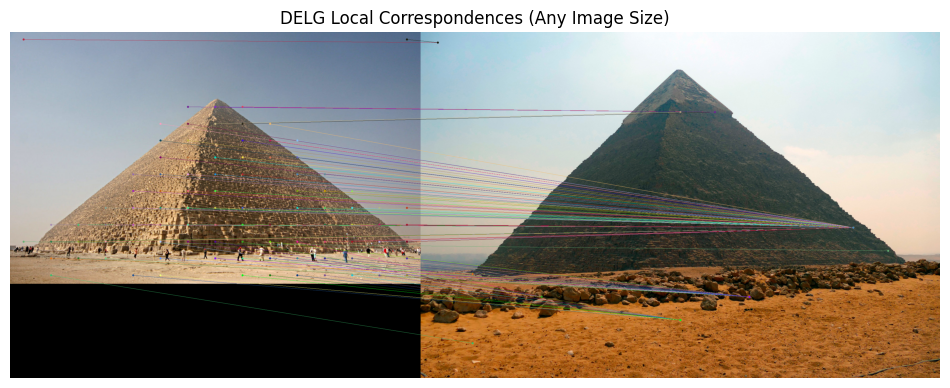

In [175]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# --- Pick two images ---
img1_path = "dataset/train_Pyramids Of Giza - Egypt_1746.jpg"
img2_path = "dataset/train_Pyramids Of Giza - Egypt_1741.jpg"

# --- Load images ---
img1 = Image.open(img1_path).convert("RGB")
img2 = Image.open(img2_path).convert("RGB")

H1, W1 = img1.size[1], img1.size[0]
H2, W2 = img2.size[1], img2.size[0]

# --- Load local descriptors from your precomputed DELG features ---
img1_idx = all_paths.index(img1_path)
img2_idx = all_paths.index(img2_path)

desc1 = all_local_feats[img1_idx]  # shape: [num_desc1, feat_dim]
desc2 = all_local_feats[img2_idx]  # shape: [num_desc2, feat_dim]

# --- Compute keypoints positions for plotting ---
# Rough grid mapping from feature descriptor positions to image pixels
feat_map_h1 = feat_map_w1 = int(np.sqrt(desc1.shape[0]))
kpts1_y = (np.arange(feat_map_h1).repeat(feat_map_w1) + 0.5) * (H1 / feat_map_h1)
kpts1_x = (np.tile(np.arange(feat_map_w1), feat_map_h1) + 0.5) * (W1 / feat_map_w1)
kpts1 = np.stack([kpts1_x, kpts1_y], axis=1)

feat_map_h2 = feat_map_w2 = int(np.sqrt(desc2.shape[0]))
kpts2_y = (np.arange(feat_map_h2).repeat(feat_map_w2) + 0.5) * (H2 / feat_map_h2)
kpts2_x = (np.tile(np.arange(feat_map_w2), feat_map_h2) + 0.5) * (W2 / feat_map_w2)
kpts2 = np.stack([kpts2_x, kpts2_y], axis=1)

# --- Compute similarity and pick top matches ---
sim = np.dot(desc1, desc2.T)
matches = [(i, np.argmax(sim[i]), sim[i, np.argmax(sim[i])]) for i in range(len(kpts1))]
matches = sorted(matches, key=lambda x: -x[2])[:100]  # top 30 matches

# --- Create canvas to combine images ---
canvas_h = max(H1, H2)
canvas_w = W1 + W2
match_img = np.zeros((canvas_h, canvas_w, 3), dtype=np.uint8)

match_img[:H1, :W1, :] = np.array(img1)
match_img[:H2, W1:W1+W2, :] = np.array(img2)

# --- Draw matches ---
for i, j, s in matches:
    x1, y1 = kpts1[i]
    x2, y2 = kpts2[j]
    x2 += W1  # offset second image x-coordinate
    color = tuple(np.random.randint(0, 255, 3).tolist())
    cv2.circle(match_img, (int(x1), int(y1)), 4, color, -1)
    cv2.circle(match_img, (int(x2), int(y2)), 4, color, -1)
    cv2.line(match_img, (int(x1), int(y1)), (int(x2), int(y2)), color, 1)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.imshow(match_img)
plt.axis('off')
plt.title("DELG Local Correspondences (Any Image Size)")
plt.show()
